In [ ]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, LeakyReLU, Dense
from sklearn.model_selection import train_test_split
import keras_tuner as kt

In [ ]:
params = {
    'latitude': 26.144518,
    'longitude' :91.736237,
    'start_date' : '2023-01-01',
    'end_date': '2023-01-31',
    'hourly': {'temperature_2m','relativehumidity_2m','windspeed_10m','vapor_pressure_deficit'}
}
result = requests.get("https://api.open-meteo.com/v1/forecast",params = params).json()
print(result)

{'latitude': 26.125, 'longitude': 91.75, 'generationtime_ms': 57.94191360473633, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 52.0, 'hourly_units': {'time': 'iso8601', 'windspeed_10m': 'km/h', 'relativehumidity_2m': '%', 'temperature_2m': '°C', 'vapor_pressure_deficit': 'kPa'}, 'hourly': {'time': ['2023-01-01T00:00', '2023-01-01T01:00', '2023-01-01T02:00', '2023-01-01T03:00', '2023-01-01T04:00', '2023-01-01T05:00', '2023-01-01T06:00', '2023-01-01T07:00', '2023-01-01T08:00', '2023-01-01T09:00', '2023-01-01T10:00', '2023-01-01T11:00', '2023-01-01T12:00', '2023-01-01T13:00', '2023-01-01T14:00', '2023-01-01T15:00', '2023-01-01T16:00', '2023-01-01T17:00', '2023-01-01T18:00', '2023-01-01T19:00', '2023-01-01T20:00', '2023-01-01T21:00', '2023-01-01T22:00', '2023-01-01T23:00', '2023-01-02T00:00', '2023-01-02T01:00', '2023-01-02T02:00', '2023-01-02T03:00', '2023-01-02T04:00', '2023-01-02T05:00', '2023-01-02T06:00', '2023-01-02T07:00', '2023-01-02T08:00

In [ ]:
result['hourly']

In [ ]:
df = pd.DataFrame(result['hourly'])

In [ ]:
df.head()

,time,windspeed_10m,relativehumidity_2m,temperature_2m,vapor_pressure_deficit
0,2023-01-01T00:00,4.0,94,11.6,0.08
1,2023-01-01T01:00,4.6,92,11.7,0.11
2,2023-01-01T02:00,4.1,87,13.9,0.21
3,2023-01-01T03:00,1.8,75,17.4,0.50
4,2023-01-01T04:00,5.0,69,19.8,0.72


In [ ]:
df.set_index("time", inplace = True)

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

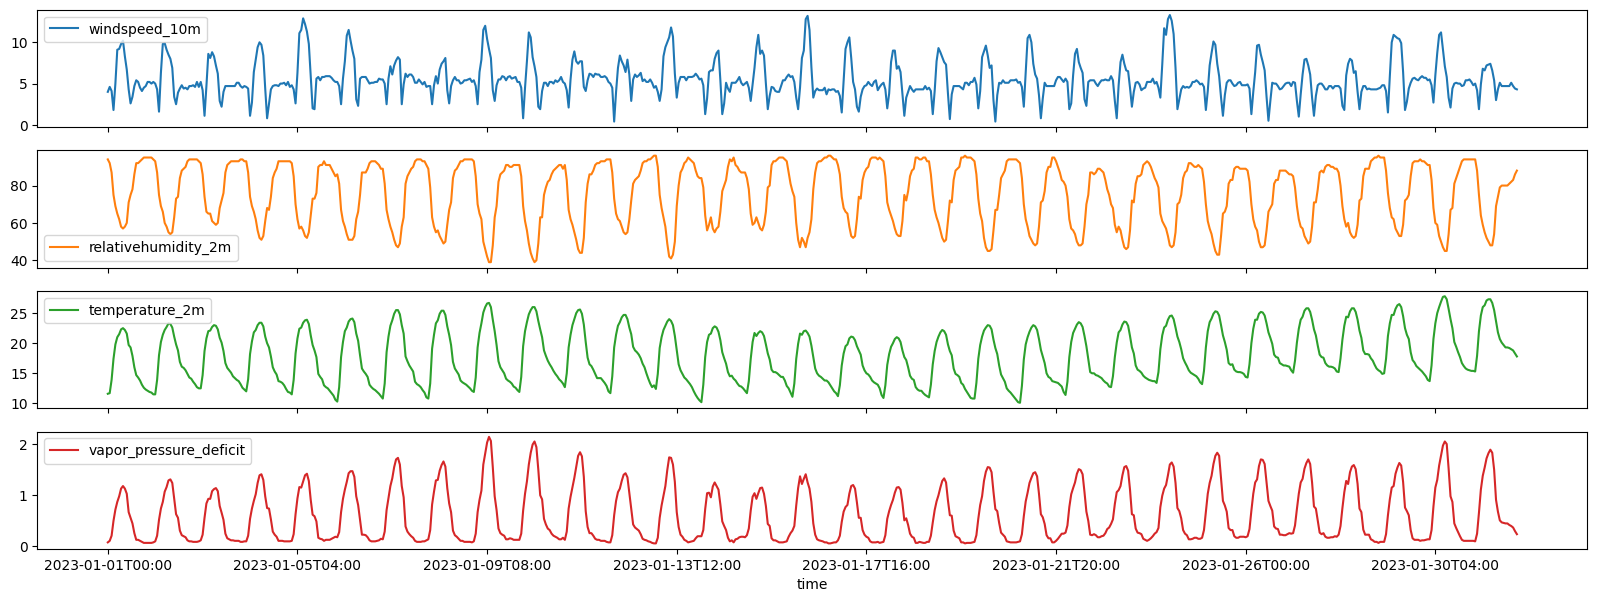

In [ ]:
df.plot(figsize = (20,7), subplots = True)

In [ ]:
df.to_csv("weather_data_2.csv")

In [ ]:
df = pd.read_csv("/content/weather_data_2.csv")

In [ ]:
df.head()

,time,temperature_2m,windspeed_10m,relativehumidity_2m,vapor_pressure_deficit
0,2023-01-01T00:00,11.6,4.0,94,0.08
1,2023-01-01T01:00,11.7,4.6,92,0.11
2,2023-01-01T02:00,13.9,4.1,87,0.21
3,2023-01-01T03:00,17.4,1.8,75,0.50
4,2023-01-01T04:00,19.8,5.0,69,0.72


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature_2m,744.0,17.897581,4.421137,10.10,14.1000,17.40,21.80,27.80
windspeed_10m,744.0,5.526613,2.197678,0.40,4.4750,5.10,6.10,13.30
relativehumidity_2m,744.0,75.549731,16.525610,39.00,60.0000,81.00,91.00,96.00
vapor_pressure_deficit,744.0,0.610484,0.537667,0.06,0.1475,0.36,1.05,2.14


In [ ]:
df.set_index("time",inplace = True)

In [ ]:
time = df.index

In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [ ]:
data

array([[0.27906977, 0.96491228, 0.08474576, 0.00961538],
       [0.3255814 , 0.92982456, 0.09039548, 0.02403846],
       [0.28682171, 0.84210526, 0.21468927, 0.07211538],
       ...,
       [0.33333333, 0.77192982, 0.49152542, 0.14903846],
       [0.31007752, 0.8245614 , 0.46327684, 0.11538462],
       [0.30232558, 0.85964912, 0.43502825, 0.08653846]])

In [ ]:
x_train,x_test, y_train,y_test = train_test_split(data,data[:,2],train_size = 0.8,shuffle = False)

In [ ]:
x_train.shape[0]

595

In [ ]:
x_test.shape[0]

149

In [ ]:
win_length = 24
batch_size = 5
num_features = 4
train_generator = TimeseriesGenerator(x_train,y_train, win_length, batch_size = batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, win_length, batch_size = batch_size)

In [ ]:
pred_time = time[595:]

In [ ]:
train_generator[0][1]

array([0.07909605, 0.07909605, 0.21468927, 0.44632768, 0.57062147])

In [ ]:
test_generator[0]

In [ ]:
model = Sequential()
model.add(LSTM(24, input_shape = (win_length, num_features), return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dropout(0.5))
model.add(LSTM(24, return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(LSTM(24, return_sequences = False))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", metrics = "mean_squared_error")

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice("units",[64,128,256,512]),activation = "tanh", input_shape = (win_length, num_features), return_sequences = True))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(LSTM(hp.Choice("units",[64,128,256,512]),activation = "tanh",  return_sequences = True))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  # model.add(LSTM(hp.Choice("units",[64,128,256,512]),activation = "tanh",  return_sequences = True))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Dropout(0.5))
  model.add(Dense(100,activation = "leaky_relu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(loss = "mean_squared_error", metrics = "accuracy")
  return model

In [ ]:
tuner = kt.GridSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    directory = 'mydir4')

In [ ]:
tuner.search(train_generator, epochs=10, validation_data= test_generator)

Trial 4 Complete [00h 11m 09s]
val_accuracy: 0.00800000037997961

Best val_accuracy So Far: 0.00800000037997961
Total elapsed time: 00h 15m 22s


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.save("model.keras")

In [ ]:
tuner.get_best_models()

In [ ]:
model = tf.keras.models.load_model("model.keras")

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17664     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 64)            0         
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 dense (Dense)               (None, 24, 100)           6500      
                                                                 
 dropout_1 (Dropout)         (None, 24, 100)           0

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 24)            2784      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 24, 24)            0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24)            0         
                                                                 
 lstm_9 (LSTM)               (None, 24, 24)            4704      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24)            0         
                                                                 
 lstm_10 (LSTM)              (None, 24)                4704      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24)               

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 15)

In [ ]:
history = model.fit(train_generator,epochs = 100,validation_data = test_generator,shuffle = False, callbacks = [callback])

Epoch 1/100
115/115 [==============================] - 9s 38ms/step - loss: 0.0882 - mean_squared_error: 0.0882 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 2/100
115/115 [==============================] - 3s 23ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/100
115/115 [==============================] - 3s 25ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 4/100
115/115 [==============================] - 3s 23ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 5/100
115/115 [==============================] - 3s 23ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 6/100
115/115 [==============================] - 3s 24ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 7/100
115/

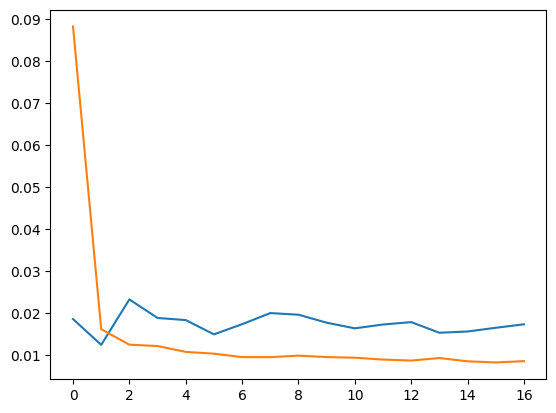

In [ ]:
plt.plot(history.history["val_loss"],label=  "val_loss")
plt.plot(history.history["loss"],label = "loss")

In [ ]:
model.save("model_3.keras")

In [ ]:
prediction  = model.predict_generator(test_generator)

<ipython-input-143-7963bfab3b74>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction  = model.predict_generator(test_generator)


In [ ]:
prediction.shape

(125, 1)

In [ ]:
x_test.shape[0]

149

In [ ]:
pred_df = pd.concat([pd.DataFrame(prediction[:,-1]),pd.DataFrame(x_test[:,1:][win_length:])], axis = 1)

In [ ]:
pred_df =  pd.DataFrame(scaler.inverse_transform(pred_df))

In [ ]:
pred_df

,0,1,2,3
0,11.521603,88.0,16.5,0.23
1,11.484573,88.0,16.3,0.22
2,11.445196,88.0,16.3,0.22
3,11.407210,87.0,16.2,0.24
4,11.242595,86.0,16.1,0.26
...,...,...,...,...
120,11.570080,81.0,19.2,0.42
121,11.570866,82.0,19.0,0.40
122,11.496518,83.0,18.8,0.37
123,11.496586,86.0,18.3,0.30


In [ ]:
test_data = pd.DataFrame(scaler.inverse_transform(pd.concat([pd.DataFrame(y_test),pd.DataFrame(x_test[:,1:])],axis = 1)))

In [ ]:
test_data

,0,1,2,3
0,11.942105,90.0,15.3,0.17
1,11.942105,90.0,15.2,0.17
2,11.715789,89.0,15.2,0.19
3,11.715789,89.0,15.1,0.19
4,11.715789,89.0,14.9,0.19
...,...,...,...,...
144,9.905263,81.0,19.2,0.42
145,10.131579,82.0,19.0,0.40
146,10.357895,83.0,18.8,0.37
147,11.036842,86.0,18.3,0.30


In [ ]:
x_test[:,1:].shape[0]

149

In [ ]:
y_test.shape[0]

149

In [ ]:
df_pred = pd.DataFrame(pred_df[0],index= pred_time[24:])

In [ ]:
df_compare = pd.concat([pred_df[0],test_data.iloc[win_length:][0]], axis = 1)
df_compare.index = pred_time
df_compare.columns = ["prediction","actual"]

NameError: ignored

<Axes: xlabel='time'>

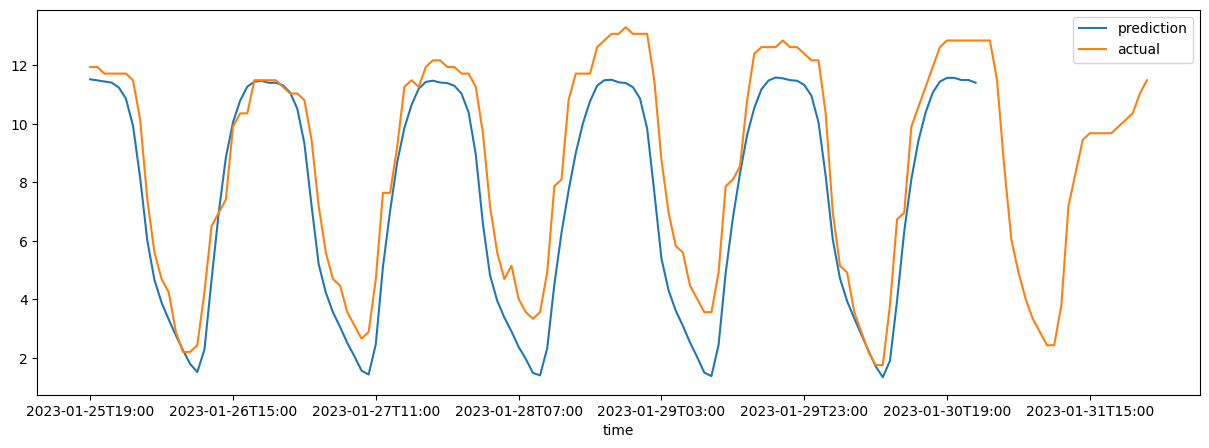

In [ ]:
df_compare.plot(figsize= (15,5))

In [ ]:
df_pred.to_csv("weather_pred.csv")
df_compare.to_csv("weather_pred_test.csv")